## Note: This notebook will run about 9 hrs and 30 mins on my computer (Intel(R) Core(TM) i7-10875H CPU @ 2.30GHz; RAM: 32.0 GB).

In [119]:
import pandas as pd
import numpy as np
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN,SVMSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import skopt
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from helper_function import bayes_tuning,grid_tuning,plot_models_comp,plot_cv_vs_test

In [103]:
print('python version:'+sys.version)
print('packages:\n'+'\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

python version:3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
packages:
pandas==1.0.5
numpy==1.20.2
sklearn==0.24.2
xgboost==1.4.2
seaborn==0.11.0
imblearn==0.7.0
skopt==0.9.dev0


In [104]:
#ingore warnings
warnings.filterwarnings("ignore")
xgboost.set_config(verbosity=0)
#to show more rows and columns in pandas Dataframe
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
#set inf in pandas Dataframe to missing values
pd.options.mode.use_inf_as_na = True

# Loading data files

## We use the 2001-2017 data from multiple databases to predict the next two years closure. 

In [105]:
#loading closed hospital status information
dataset_close_status=pd.read_csv('data\hospital_closure\hospital_closure.csv')
#loading closed hospital information
dataset=pd.read_csv('data\hospital_closure\hosp_closest_info_v5.csv',thousands=',')

In [106]:
#function that check if the year is 1 or 2 year prior to closure
def check(a, b):
    if  a == b-1 or a == b-2:
        return 1
    else:
        return 0

In [107]:
#drop the year without y label
dataset.drop(dataset[dataset['year']==2017].index,inplace=True)
#assign Closure label
dataset['Closure']=dataset.apply(lambda x:1 if int(x['provider']) in np.array(dataset_close_status['id']) and check(float(x['year']),int(dataset_close_status[dataset_close_status['id']==int(x['provider'])]['year_close_combined'])) else 0,axis=1)

In [108]:
#manually assign the closed hospital due to mergers and natural disaster
dataset['provider']=pd.to_numeric(dataset['provider']).astype(int)
dataset.loc[dataset['provider']==200025,'Closure']=0
dataset.loc[dataset['provider']==260147,'Closure']=0
dataset.loc[dataset['provider']==440047,'Closure']=0
dataset.loc[dataset['provider']==180149,'Closure']=0
dataset.loc[dataset['provider']==450832,'Closure']=0
dataset.loc[dataset['provider']==670052,'Closure']=0
dataset.loc[dataset['provider']==330225,'Closure']=0
dataset.loc[dataset['provider']==360347,'Closure']=0
dataset.loc[dataset['provider']==390108,'Closure']=0
dataset.loc[dataset['provider']==150170,'Closure']=0
dataset.loc[dataset['provider']==40142,'Closure']=0
dataset.loc[dataset['provider']==390131,'Closure']=0
dataset.loc[dataset['provider']==390010,'Closure']=0
dataset.loc[dataset['provider']==330036,'Closure']=0

#drop all the other year except the predictive year
dataset['other']=dataset.apply(lambda x:1 if int(x['provider']) in np.array(dataset_close_status['id']) and x['Closure']==0 else 0,axis=1)
dataset.drop(dataset[dataset['other']==1].index,inplace=True)
dataset.drop(columns=['other'],inplace=True)

#set 'Not Available' and infinity values as missing values
dataset.replace({'Not Available':np.nan,' Not Available':np.nan},inplace=True)
dataset.replace({np.inf:np.nan},inplace=True)

In [109]:
#drop all the other year except the predictive year
dataset['other']=dataset.apply(lambda x:1 if int(x['provider']) in np.array(dataset_close_status['id']) and x['Closure']==0 else 0,axis=1)
dataset.drop(dataset[dataset['other']==1].index,inplace=True)
dataset.drop(columns=['other'],inplace=True)

#set 'Not Available' and infinity values as missing values
dataset.replace({'Not Available':np.nan,' Not Available':np.nan},inplace=True)
dataset.replace({np.inf:np.nan},inplace=True)

In [110]:
#set 'Not Available' and infinity values as missing values
dataset.replace({'Not Available':np.nan,' Not Available':np.nan},inplace=True)
dataset.replace({np.inf:np.nan},inplace=True)

In [111]:
#manually select variables
dataset_=dataset[['provider','year','dshpct','ime1','dsh1','gme_part_a','gme_part_b','beds','bed_days','medicare_days','medicaid_days','days','employees','medicare_disch','medicaid_disch','discharges','ind_dsh','ind_teaching','efficiency','utilization',
                'overall','doc_communicate','nurse_communicate','help_quick','staff_explain','pain_control','area_quiet','room_clean','discharge_info','recommend','survey_response_rate',
                'mortality','safety','readmin','patient_exp','effective','timely',
                'hsanum','prop_discharges','rural_urban','pop','unemp','poverty','under_65',
                'prop_phy_pcp','prop_md_pcp','prop_pcp','prop_gi','prop_gen_int','prop_hosp','prop_hosp_short','prop_cah','prop_hosp_adm','prop_hosp_adm_short','prop_hosp_bed','prop_hosp_bed_short','prop_days_inp','prop_days_inp_short','prop_days_inp_med','Closure']]

for col in dataset_:
    dataset_[col]=pd.to_numeric(dataset_[col])
    
#drop duplicates
dataset_.drop_duplicates(inplace=True)                

## summary statistics

In [112]:
dataset_stat=dataset_.copy()
dataset_stat.drop(columns=['provider','year'],inplace=True)

In [113]:
dataset_stat[dataset_stat['Closure']==1].describe()
#dataset_stat[dataset_stat['Closure']==1].describe().T.to_clipboard()

,dshpct,ime1,dsh1,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,ind_dsh,ind_teaching,efficiency,utilization,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,mortality,safety,readmin,patient_exp,effective,timely,hsanum,prop_discharges,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure
count,103.000000,1.400000e+01,2.130000e+02,6.700000e+01,6.800000e+01,273.000000,273.000000,273.000000,121.000000,273.000000,272.000000,273.000000,268.000000,273.000000,273.000000,273.000000,273.000000,273.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,142.000000,10.0,2.000000,10.000000,4.0,9.000000,10.000000,262.000000,262.000000,260.000000,2.600000e+02,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,273.0
mean,0.137472,4.086954e+05,1.495094e+06,1.373333e+06,3.291708e+05,100.234432,34675.930403,5995.948718,786.652893,14715.886447,405.109890,1066.835165,508.406716,3139.007326,0.780220,0.256410,27.897464,0.331354,63.069930,81.531469,75.811189,65.195804,61.538462,69.314685,63.426573,70.741259,80.881119,63.426573,27.866197,2.0,2.333333,2.066667,1.0,1.777778,1.800000,26307.049618,1356.423984,2.830769,1.282387e+06,9.541538,17.922692,83.140217,0.000653,0.000586,0.002904,0.000038,0.000360,0.000033,0.000028,0.000006,0.122851,0.113176,0.003692,0.003117,0.876858,0.709742,0.276626,1.0
std,0.120685,6.785471e+05,2.504180e+06,2.731693e+06,7.963202e+05,74.765442,27498.788505,7657.808906,1550.257934,18877.521268,533.611115,1182.565795,837.698395,3645.388232,0.414858,0.437453,18.378626,0.212722,11.283573,7.457678,7.979685,11.934244,9.327960,8.068736,12.274151,8.702204,6.298323,11.419337,8.492992,0.0,0.000000,0.140546,0.0,0.440959,0.421637,15427.116774,1151.099023,2.332045,2.212389e+06,2.416459,5.464613,3.908222,0.000285,0.000280,0.002509,0.000040,0.000303,0.000044,0.000045,0.000039,0.069885,0.061135,0.002846,0.002637,0.875089,0.800720,0.157393,0.0
min,0.027000,1.360000e+02,1.110000e+02,3.000000e+00,1.400000e+02,4.000000,1460.000000,2.000000,1.000000,80.000000,17.400000,1.000000,1.000000,17.000000,0.000000,0.000000,0.253731,0.009315,35.000000,63.000000,54.000000,37.000000,41.000000,49.000000,34.000000,51.000000,64.000000,35.000000,7.000000,2.0,2.333333,2.000000,1.0,1.000000,1.000000,1001.000000,171.779541,1.000000,7.750000e+02,5.000000,6.300000,69.183910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.063450,4.095975e+04,9.359000e+04,9.154700e+04,2.624350e+04,39.000000,12775.000000,1265.000000,62.000000,2800.000000,121.112500,276.000000,33.750000,672.000000,1.000000,0.000000,13.351350,0.154930,57.000000,77.000000,73.000000,57.500000,56.000000,65.000000,55.000000,65.000000,77.000000,56.000000,23.000000,2.0,2.333333,2.000000,1.0,2.000000,2.000000,12504.000000,453.818600,1.000000,4.389500e+04,7.900000,14.775000,80.826985,0.000458,0.000393,0.000987,0.000000,0.000123,0.000012,0.000008,0.000000,0.081267,0.079989,0.002143,0.001800,0.416846,0.384909,0.177140,1.0
50%,0.120000,2.039080e+05,3.795870e+05,2.657150e+05,7.165000e+04,92.000000,28470.000000,2897.000000,236.000000,6933.000000,251.625000,597.000000,142.000000,1703.000000,1.000000,0.000000,25.910710,0.297439,63.000000,82.000000,76.000000,65.000000,61.000000,69.000000,63.000000,70.000000,82.000000,64.000000,28.000000,2.0,2.333333,2.000000,1.0,2.000000,2.000000,31021.000000,977.566800,2.000000,4.369290e+05,9.300000,17.050000,83.945865,0.0

In [114]:
dataset_stat[dataset_stat['Closure']==0].describe()
#dataset_stat[dataset_stat['Closure']==0].describe().T.to_clipboard()

,dshpct,ime1,dsh1,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,ind_dsh,ind_teaching,efficiency,utilization,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,survey_response_rate,mortality,safety,readmin,patient_exp,effective,timely,hsanum,prop_discharges,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,Closure
count,17430.000000,6.825000e+03,4.351200e+04,1.786300e+04,1.851400e+04,93519.000000,9.353000e+04,93053.000000,33600.000000,93532.000000,9.312500e+04,93067.000000,84514.000000,93532.000000,93532.000000,93532.000000,93532.000000,93532.000000,32089.000000,32089.000000,32090.000000,32085.000000,32051.000000,32069.000000,32090.000000,32089.000000,32082.000000,32089.000000,32012.000000,53100.000000,41947.000000,58848.000000,52973.000000,56662.000000,55697.000000,91543.000000,91543.000000,88012.000000,8.801200e+04,88012.000000,88012.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,87963.000000,93532.0
mean,0.157948,6.582460e+06,2.954007e+06,2.015881e+06,6.114782e+05,131.450144,5.910190e+04,11177.468593,4206.286488,30395.886734,8.412160e+02,1925.274899,885.933112,5738.417953,0.466183,0.195131,34.721688,0.518101,68.758079,80.891302,77.350608,65.682375,62.250008,69.919548,59.407759,72.072953,83.828066,70.147216,32.178652,2.012385,2.064510,2.005477,2.010691,1.962738,2.033622,26413.336345,1545.570479,3.862746,6.745344e+05,8.671264,16.177100,82.537362,0.000715,0.000637,0.002832,0.000035,0.000300,0.000048,0.000040,0.000027,0.127583,0.118232,0.004128,0.003442,0.947770,0.752823,0.299285,0.0
std,0.125416,1.162989e+07,4.898438e+06,3.589617e+06,1.173957e+06,156.532205,3.590609e+06,15276.130435,9067.818311,43916.100678,1.238123e+04,2704.899847,1694.676790,8488.140818,0.498858,0.396304,20.587623,0.231184,9.448371,5.507018,6.332883,9.450779,7.244841,5.916824,10.506461,8.094301,5.336317,10.049266,9.345150,0.444914,0.647954,0.660622,0.782702,0.274104,0.729207,15006.215063,1248.296945,7.171394,1.531273e+06,2.610838,5.545352,7.091832,0.000334,0.000317,0.002574,0.000042,0.000297,0.000072,0.000068,0.000074,0.088099,0.081710,0.003979,0.003243,1.123642,0.822378,0.249172,0.0
min,0.001000,1.500000e+02,5.600000e+01,-1.744730e+05,-3.667300e+04,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000e-02,1.000000,1.000000,1.000000,0.000000,0.000000,0.006303,0.000040,10.000000,14.000000,8.000000,11.000000,1.000000,0.000000,0.000000,6.000000,27.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1001.000000,163.905971,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.082600,5.823350e+05,3.308132e+05,1.618500e+05,3.447900e+04,25.000000,9.150000e+03,1854.000000,171.000000,4139.750000,1.228300e+02,253.000000,43.000000,550.000000,0.000000,0.000000,16.750000,0.338299,63.000000,77.000000,74.000000,60.000000,58.000000,67.000000,52.000000,67.000000,81.000000,64.000000,26.000000,2.000000,1.666667,1.666667,1.000000,2.000000,1.333333,14063.000000,602.694900,1.000000,3.333500e+04,7.000000,12.300000,80.735670,0.000499,0.000426,0.001119,0.000000,0.000107,0.000015,0.000010,0.000000,0.071771,0.068634,0.002142,0.001823,0.381396,0.334610,0.156704,0.0
50%,0.120000,2.153619e+06,1.101722e+06,6.907300e+05,1.834315e+05,72.000000,2.555000e+04,5243.000000,955.000000,13068.500000,2.993700e+02,747.000000,245.000000,2003.000000,0.000000,0.000000,35.200000,0.531443,69.000000,81.000000,78.000000,65.000000,62.000000,70.0000

## Missing values

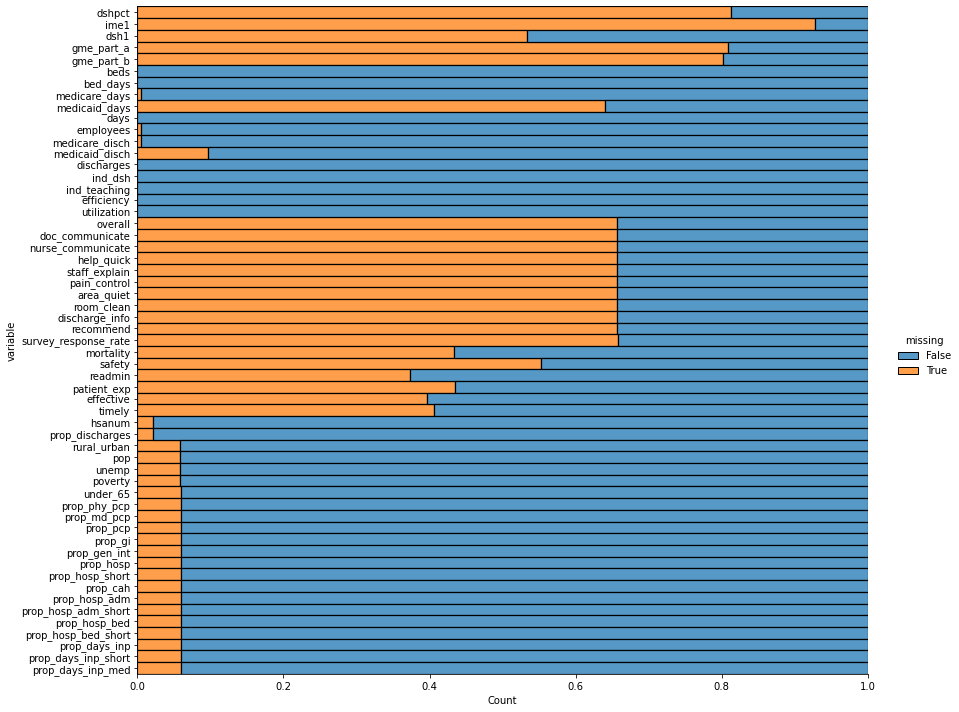

In [116]:
sns.displot(
    data=dataset_.copy().drop(columns=['provider','year','Closure']).isna().melt(value_name="missing"),
    
    y="variable",
    hue="missing",
    multiple="fill",
    height=10,
    aspect=1.25
)
plt.show()

In [117]:
# fill the variables with lower than 50% missing values by median value
list_fill_median=[]
for col in dataset_:
    if dataset_[col].isna().mean()<0.5:
        list_fill_median.append(col)
for col in list_fill_median:
    dataset_[col].fillna(dataset_[col].median(),inplace=True)

#save provider id and year data for future matching
match_id=np.array(dataset_['provider'])
dataset_.drop(columns=['provider'],inplace=True)
#save year data for future matching
match_year=np.array(dataset_['year'])
dataset_.drop(columns=['year'],inplace=True)
col_list=list(dataset_)
Y=dataset_['Closure']
dataset_.drop(columns=['Closure'],inplace=True)

#multiple imputation
imputer_i=IterativeImputer(max_iter=1)
imputer_i.fit(dataset_)
dataset_=imputer_i.transform(dataset_)

In [118]:
dataset_=np.concatenate((dataset_,Y.to_numpy().reshape(dataset_.shape[0],1)),axis=1)
#save data for future matching
dataset_to_match=pd.DataFrame(data=dataset_.copy(),columns=col_list)
dataset_to_match=dataset_to_match.assign(year=match_year,id=match_id)
dataset_to_match.to_csv('data/hosp_c.csv')

In [86]:
X_train, X_test, y_train, y_test = train_test_split(dataset_[:,:-1],
                                                    dataset_[:,-1],
                                                    test_size=0.1,
                                                    stratify=dataset_[:,-1]
                                                    )
stratified_kfold = StratifiedKFold(n_splits=10)

# tuning and cross-validation

### Logistic Regression

In [41]:
classifier=LogisticRegression()
param_space={'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

oversampling=None
cv_score_LR,test_score_LR,list_best_cv_LR=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_LR_r,test_score_LR_r,list_best_cv_LR_r=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_LR_s,test_score_LR_s,list_best_cv_LR_s=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_LR_a,test_score_LR_a,list_best_cv_LR_a=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_LR_svm,test_score_LR_svm,list_best_cv_LR_svm=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: LogisticRegression()
Over-sampling strategy: None
Cross-validation score: 0.0
Test score: 0.0
Best parameters: {'classifier__C': 0.001}

Classifier: LogisticRegression()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.012616341947150842
Test score: 0.012830188679245284
Best parameters: {'classifier__C': 0.01}

Classifier: LogisticRegression()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.01245454988090178
Test score: 0.011469534050179211
Best parameters: {'classifier__C': 1}

Classifier: LogisticRegression()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.01259519643914589
Test score: 0.011564871702204554
Best parameters: {'classifier__C': 0.001}

Classifier: LogisticRegression()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.024139666027298314
Test score: 0.01873536299765808
Best parameters: {'classifier__C': 0.01}



### K-NN

In [44]:
classifier=KNeighborsClassifier()
param_space={'classifier__n_neighbors':[1,2,3,5]}

oversampling=None
cv_score_knn,test_score_knn,list_best_cv_knn=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_knn_r,test_score_knn_r,list_best_cv_knn_r=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_knn_s,test_score_knn_s,list_best_knn_s=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_knn_a,test_score_knn_a,list_best_knn_a=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_knn_svm,test_score_knn_svm,list_best_cv_knn_svm=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: KNeighborsClassifier()
Over-sampling strategy: None
Cross-validation score: 0.012499999999999997
Test score: 0.04081632653061224
Best parameters: {'classifier__n_neighbors': 1}

Classifier: KNeighborsClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.05620913782992004
Test score: 0.04395604395604395
Best parameters: {'classifier__n_neighbors': 5}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.020409552016852465
Test score: 0.03082851637764933
Best parameters: {'classifier__n_neighbors': 5}

Classifier: KNeighborsClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.016042966042966046
Test score: 0.047619047619047616
Best parameters: {'classifier__n_neighbors': 2}

Classifier: KNeighborsClassifier()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.054890413493437006
Test score: 0.049180327868852465
Best parameters: {'classifier__n_neighbors': 3}



### Decision Tree

In [34]:
classifier=DecisionTreeClassifier()
param_space={'classifier__criterion':Categorical(['gini','entropy']),
            'classifier__max_depth': Integer(1,1000),
            'classifier__splitter':Categorical(['best','random']),
            'classifier__min_samples_split': Integer(2,50),
            'classifier__min_samples_leaf': Integer(1,50),
            'classifier__max_features':Categorical(['auto','sqrt','log2',None])
            }

oversampling=None
cv_score_dt,test_score_dt,list_best_cv_dt=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler()
cv_score_dt_r,test_score_dt_r,list_best_cv_dt_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_dt_s,test_score_dt_s,list_best_cv_dt_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_dt_a,test_score_dt_a,list_best_cv_dt_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_dt_svm,test_score_dt_svm,list_best_cv_dt_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: DecisionTreeClassifier()
Over-sampling strategy: None
Cross-validation score: 0.3686829927124206
Test score: 0.27999999999999997
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.4373215461947962
Test score: 0.22222222222222224
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 1000, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 50, 'classifier__splitter': 'random'}

Classifier: DecisionTreeClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.3852895415516383
Test score: 0.3333333333333333
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 517, 'classifier__max_features':

### Random Forest

In [90]:
classifier=RandomForestClassifier()
param_space={'classifier__n_estimators':[100,200,300,400,500]}

#can turn to bayesian opt but it costs much more time (around 17 hours on my computer)
#param_space={'classifier__n_estimators':Integer(100,3000),'classifier__criterion':Categorical(['gini','entropy']),'classifier__max_depth': Integer(1,3000),'classifier__min_samples_split': Integer(2,50),'classifier__min_samples_leaf': Integer(1,50),'classifier__max_features':Categorical(['auto','sqrt','log2']),'classifier__max_leaf_nodes': Integer(2,50),'classifier__min_weight_fraction_leaf': Real(0,0.5)}

oversampling=None
cv_score_rf,test_score_rf,list_best_cv_rf=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
#cv_score_rf,test_score_rf,list_best_cv_rf=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=RandomOverSampler() 
cv_score_rf_r,test_score_rf_r,list_best_cv_rf_r=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
#cv_score_rf_r,test_score_rf_r,list_best_cv_rf_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_rf_s,test_score_rf_s,list_best_cv_rf_s=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
#cv_score_rf_s,test_score_rf_s,list_best_cv_rf_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_rf_a,test_score_rf_a,list_best_cv_rf_a=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
#cv_score_rf_a,test_score_rf_a,list_best_cv_rf_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_rf_svm,test_score_rf_svm,list_best_cv_rf_svm=grid_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)
#cv_score_rf_svm,test_score_rf_svm,list_best_cv_rf_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: RandomForestClassifier()
Over-sampling strategy: None
Cross-validation score: 0.015692307692307693
Test score: 0.0
Best parameters: {'classifier__n_estimators': 100}

Classifier: RandomForestClassifier()
Over-sampling strategy: RandomOverSampler()
Cross-validation score: 0.30015157313127283
Test score: 0.07142857142857142
Best parameters: {'classifier__n_estimators': 100}

Classifier: RandomForestClassifier()
Over-sampling strategy: SMOTE()
Cross-validation score: 0.48174586640153355
Test score: 0.32432432432432434
Best parameters: {'classifier__n_estimators': 200}

Classifier: RandomForestClassifier()
Over-sampling strategy: ADASYN()
Cross-validation score: 0.4834751150336743
Test score: 0.43902439024390244
Best parameters: {'classifier__n_estimators': 200}

Classifier: RandomForestClassifier()
Over-sampling strategy: SVMSMOTE()
Cross-validation score: 0.3012299349396124
Test score: 0.19999999999999998
Best parameters: {'classifier__n_estimators': 100}



### XGBoost

In [36]:
classifier=XGBClassifier(booster='gbtree',tree_method='hist')
param_space={'classifier__learning_rate': (0.01, 1.0, 'log-uniform'),
             'classifier__min_child_weight': (0, 10),
             'classifier__max_depth': (1, 100),
             'classifier__max_delta_step': (0, 10),
             'classifier__subsample': (0.01, 1.0, 'uniform'),             
             'classifier__alpha': (1e-5, 1.0, 'log-uniform'),
             'classifier__n_estimators': (100, 600)   
        }

oversampling=None
cv_score_xg,test_score_xg,list_best_cv_xg=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space) 
       
oversampling=RandomOverSampler()
cv_score_xg_r,test_score_xg_r,list_best_cv_xg_r=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SMOTE()
cv_score_xg_s,test_score_xg_s,list_best_cv_xg_s=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=ADASYN()
cv_score_xg_a,test_score_xg_a,list_best_cv_xg_a=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

oversampling=SVMSMOTE()
cv_score_xg_svm,test_score_xg_svm,list_best_cv_xg_svm=bayes_tuning(X_train, y_train,X_test, y_test,stratified_kfold,oversampling,classifier,param_space)

Classifier: XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='hist',
              validate_parameters=None, verbosity=None)
Over-sampling strategy: None
Cross-validation score: 0.44261911253192415
Test score: 0.13793103448275862
Best parameters: {'classifier__alpha': 0.0007943755688944848, 'classifier__learning_rate': 0.7745651705097975, 'classifier__max_delta_step': 10, 'classifier__max_depth': 69, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 600, 'cl

# Results' Plots

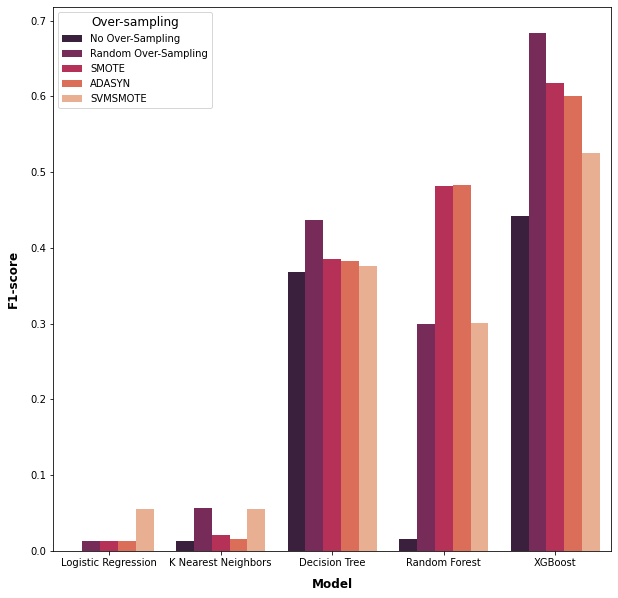

In [91]:
#Model comparison of cross-validation score
models_comparsion = pd.DataFrame({
    'Model': ['Logistic Regression','K Nearest Neighbors',
              'Decision Tree','Random Forest', 
              'XGBoost'],
    'No Over-Sampling':[cv_score_LR,cv_score_knn,cv_score_dt,cv_score_rf,cv_score_xg],
    'Random Over-Sampling':[cv_score_LR_r,cv_score_knn_r,cv_score_dt_r,cv_score_rf_r,cv_score_xg_r],
    'SMOTE': [cv_score_LR_s,cv_score_knn_s,cv_score_dt_s,cv_score_rf_s,cv_score_xg_s],
    'ADASYN': [cv_score_LR_a,cv_score_knn_a,cv_score_dt_a,cv_score_rf_a,cv_score_xg_a],
    'SVMSMOTE':[cv_score_LR_svm,cv_score_knn_svm,cv_score_dt_svm,cv_score_rf_svm,cv_score_xg_svm]
    })

plot_models_comp(models_comparsion)

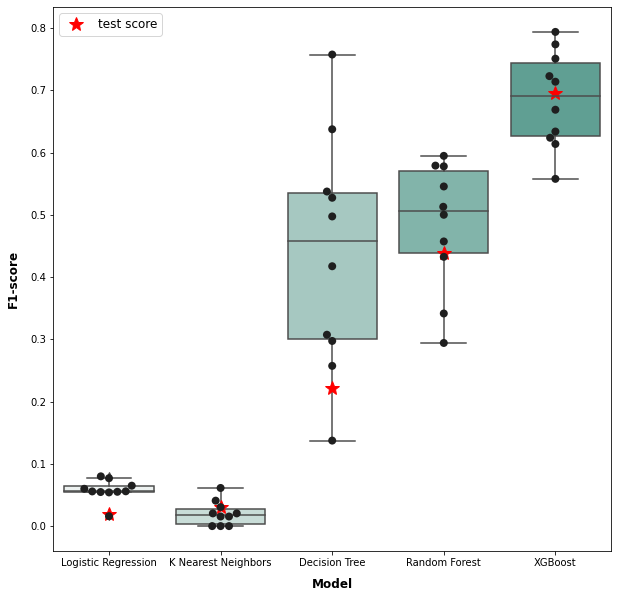

In [97]:
#Comparison of cross-validation score and test score of models with best over-sampling
cv_score=pd.DataFrame({
    'Logistic Regression':list_best_cv_LR_svm,
    'K Nearest Neighbors':list_best_cv_knn_s,
    'Decision Tree':list_best_cv_dt_r,
    'Random Forest':list_best_cv_rf_a, 
    'XGBoost':list_best_cv_xg_s
    })
test_score={
    'Logistic Regression':test_score_LR_svm,
    'K Nearest Neighbors':test_score_knn_s,
    'Decision Tree':test_score_dt_r,
    'Random Forest':test_score_rf_a, 
    'XGBoost':test_score_xg_s
    }
    
plot_cv_vs_test(cv_score,test_score)